<a href="https://colab.research.google.com/github/talhaanwarch/my_pytorch/blob/master/test_segmentation_PL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
!pip install pytorch-lightning
!pip install torchmetrics

In [10]:
!pip install monai-weekly

     |████████████████████████████████| 583kB 5.9MB/s 


In [2]:
import  pytorch_lightning as pl
print(pl.__version__)

1.3.8


# basic libs

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

#create dummy data

In [7]:
import os
os.mkdir('data')

In [16]:
from monai.data import ArrayDataset, create_test_image_3d
import nibabel as nib

root_dir='/content/data'
for i in range(40):
    im, seg = create_test_image_3d(128, 128, 64, num_seg_classes=1)

    n = nib.Nifti1Image(im, np.eye(4))
    nib.save(n, os.path.join(root_dir, f"im{i}.nii.gz"))

    n = nib.Nifti1Image(seg, np.eye(4))
    nib.save(n, os.path.join(root_dir, f"seg{i}.nii.gz"))

images = sorted(glob.glob(os.path.join(root_dir, "im*.nii.gz")))
segs = sorted(glob.glob(os.path.join(root_dir, "seg*.nii.gz")))

# transformation and data loading

In [19]:
import torch

In [21]:
from monai import transforms 
# Define transforms for image and segmentation
imtrans = transforms.Compose(
    [
        transforms.LoadImage(image_only=True),
        transforms.ScaleIntensity(),
        transforms.AddChannel(),
        transforms.RandSpatialCrop((96, 96, 96), random_size=False),
        transforms.ToTensor(),
    ]
)
segtrans = transforms.Compose(
    [
        transforms.LoadImage(image_only=True),
        transforms.AddChannel(),
        transforms.RandSpatialCrop((96, 96, 96), random_size=False),
        transforms.ToTensor(),
    ]
)



In [22]:
# Define nifti dataset, dataloader
ds = ArrayDataset(images, imtrans, segs, segtrans)
loader = torch.utils.data.DataLoader(ds, batch_size=10)
im, seg = next(iter(loader))
print(im.shape, seg.shape)

torch.Size([10, 1, 96, 96, 64]) torch.Size([10, 1, 96, 96, 64])


In [26]:
from monai.networks.nets import UNet

model=UNet(
                      dimensions=3,
                      in_channels=1,
                      out_channels=1,
                      channels=(16, 32, 64, 128, 256),
                      strides=(2, 2, 2, 2),
                      num_res_units=2,
                  )
   

In [29]:
x=torch.randn(1,1,96,96,64)
out=model(x)
out.shape

torch.Size([1, 1, 96, 96, 64])

In [40]:
from sklearn.model_selection import train_test_split
train_img,val_img,train_seg,val_seg=train_test_split(images,segs,test_size=0.2)
train_img,test_img,train_seg,test_seg=train_test_split(train_img,train_seg,test_size=0.2)

In [42]:
print('train_img', len(train_img), 'train_seg', len(train_seg))
print('val_img', len(val_img), 'val_seg', len(val_seg))
print('test_img', len(test_img), 'test_seg', len(test_seg))

train_img 25 train_seg 25
val_img 8 val_seg 8
test_img 7 test_seg 7


# Create Model, Loss, Optimizer

In [36]:
from pytorch_lightning import seed_everything, LightningModule, Trainer
from pytorch_lightning.callbacks import EarlyStopping,ModelCheckpoint
from monai.losses import DiceLoss


In [37]:
import torch.nn as nn
class OurModel(LightningModule):
  def __init__(self):
    super(OurModel,self).__init__()
    #architecute
    self.layer = UNet(
                      dimensions=3,
                      in_channels=1,
                      out_channels=1,
                      channels=(16, 32, 64, 128, 256),
                      strides=(2, 2, 2, 2),
                      num_res_units=2,
                  )

  #parameters
    self.lr=1e-3
    self.batch_size=8
    self.numworker=1
    self.criterion=DiceLoss(sigmoid=True)
    
  def forward(self,x):
    return self.layer(x)


  def configure_optimizers(self):
    opt=torch.optim.Adam(self.parameters(), lr=self.lr)
    return opt

  def train_dataloader(self):
    ds = ArrayDataset(train_img, imtrans, train_seg, segtrans)
    loader = torch.utils.data.DataLoader(ds, batch_size=self.batch_size)
    return loader

  def training_step(self,batch,batch_idx):
    image,segment=batch
    out=self(image)
    loss=self.criterion(out,segment)

    self.log('train/loss', loss, on_epoch=True,prog_bar=True)
    return loss

  def val_dataloader(self):
    ds = ArrayDataset(test_img, imtrans, test_seg, segtrans)
    loader = torch.utils.data.DataLoader(ds, batch_size=self.batch_size)
    return loader
    
  def validation_step(self,batch,batch_idx):
    image,segment=batch
    out=self(image)
    loss=self.criterion(out,segment)
    self.log('val/loss', loss, on_epoch=True,prog_bar=True)
    return loss


In [38]:
model = OurModel()
trainer = Trainer(max_epochs=1, auto_lr_find=False, auto_scale_batch_size=False,
                  tpu_cores=8,precision=16,
                  #gpus=-1,
                  progress_bar_refresh_rate=30)

GPU available: False, used: False
TPU available: True, using: 8 TPU cores


In [39]:
trainer.fit(model)


  | Name      | Type     | Params
---------------------------------------
0 | layer     | UNet     | 4.8 M 
1 | criterion | DiceLoss | 0     
---------------------------------------
4.8 M     Trainable params
0         Non-trainable params
4.8 M     Total params
9.611     Total estimated model params size (MB)


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/plugins/training_type/tpu_spawn.py:193: UserWarning: cleaning up ddp environment...
  rank_zero_warn("cleaning up ddp environment...")


In [60]:
ds = ArrayDataset(test_img, imtrans, test_seg, segtrans)
test_loader = torch.utils.data.DataLoader(ds, batch_size=2)
model.eval()
with torch.no_grad():
  imgs,preds,labels=[],[],[]
  for img, seg in test_loader:
    pred=model(img)
    img=img.detach().numpy()
    pred=pred.detach().numpy()
    seg=seg.detach().numpy()
    imgs.append(img)
    preds.append(pred)
    labels.append(seg)

In [61]:
img.shape,pred.shape,seg.shape

((1, 1, 96, 96, 64), (1, 1, 96, 96, 64), (1, 1, 96, 96, 64))

In [63]:
imgs_array=np.concatenate(imgs)
preds_array=np.concatenate(preds)
labels_array=np.concatenate(labels)
imgs_array.shape,preds_array.shape,labels_array.shape

((7, 1, 96, 96, 64), (7, 1, 96, 96, 64), (7, 1, 96, 96, 64))

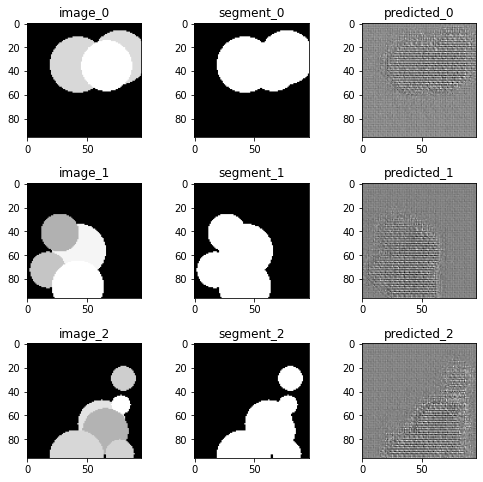

In [78]:
fig,ax=plt.subplots(3,3,figsize=(16,8))
for i in range(3):
  ax[i,0].imshow(imgs_array[i,0,:,:,48],cmap='gray')
  ax[i,0].set_title('image_{}'.format(i))
  ax[i,1].imshow(labels_array[i,0,:,:,48],cmap='gray')
  ax[i,1].set_title('segment_{}'.format(i))
  ax[i,2].imshow(preds_array[i,0,:,:,48],cmap='gray')
  ax[i,2].set_title('predicted_{}'.format(i))
plt.subplots_adjust(wspace=-0.7, hspace=0.4)
